## Text Classfication

[Kaggle Comptition Link](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

[Dropout Methods](https://mirror-medium.com/?m=https%3A%2F%2Ftowardsdatascience.com%2F12-main-dropout-methods-mathematical-and-visual-explanation-58cdc2112293)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
!pip install unidecode
!pip install word2number
!pip install contractions
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.5 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics


from keras import layers,models

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
import contractions# load spacy model, can be "en_core_web_sm" as well
nlp = spacy.load('en_core_web_md')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', 100000)

# EDA

In [ ]:
Data_toxic = pd.read_csv("/content/train.csv" , engine='python', encoding='utf-8', error_bad_lines=False)

Skipping line 104289: unexpected end of data


In [ ]:
Data_toxic.sample()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
98963,115f7ab15c5f7b66,"Yes, the territorial evolution animation is very cool. Perhaps, with the other suggested removals, we could enlarge this animation somewhat, since we'd have more room in the History section, with only two other images there. My suggestion of Toronto was just one idea of an image to put in the Demographics section. I'm sure there are plenty of other possibilities.\n \nVery much agree with the removal of images; I wanted to bring it up myself, but was too lazy to do so. I agree with Jkelly and thirty-seven's suggestions.",0,0,0,0,0,0


In [ ]:
Data_toxic.duplicated().sum()

0

In [ ]:
Data_toxic.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
def get_Catgory_values(data):
    value_count = []
    for i in list(data.columns):
        value_count.append((i , data[i].sum()))
    return pd.DataFrame(value_count , columns=["Label" , "Value count"])    

In [ ]:
get_Catgory_values(Data_toxic.iloc[: ,2:])

,Label,Value count
0,toxic,10033
1,severe_toxic,1036
2,obscene,5546
3,threat,327
4,insult,5173
5,identity_hate,893


In [ ]:
def Visualize_categories(data):
    df = Data_toxic.sum(axis=1).value_counts().reset_index()
    plt.bar(df["index"] , df[0])

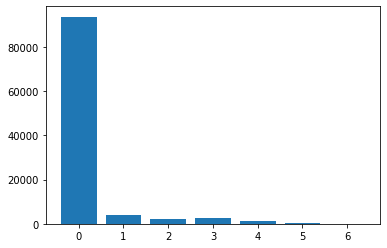

In [ ]:
Visualize_categories(Data_toxic.iloc[: ,2:])

## Data Pre-processing 

### Remove stop words

In [ ]:
Data_toxic["not_toxic"] = Data_toxic.iloc[:,2:7].sum(axis=1).apply(lambda x : 0 if x > 0 else 1)

In [ ]:
Data_toxic.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,not_toxic
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,1
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0,1


In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
for w in stop_words:
    nlp.vocab[w].is_stop = False

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
## Pre-processing Function

In [ ]:
def Clean_withRegx(text):
    return " ".join(re.sub("([\@|\#|\_]+)|([^0-9A-Za-z \t])", " ",text).split())

def text_preprocessing(text):
    """Remove  """ 
    text = Clean_withRegx(text)

    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ")
    
    """remove extra whitespaces from text"""
    text = text.strip()
    text =  " ".join(text.split())

    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    
    """keep it all Lower"""
    text = text.lower()
    
    """tokenise text"""
    doc = nlp(text) 
    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        
        """remove stop words"""
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False
            
        """remove punctuations"""    
        if token.pos_ == 'PUNCT' and flag == True: 
            flag = False
            
        """remove special characters """ 
        if token.pos_ == 'SYM' and flag == True: 
            flag = False
            
        """remove numbers"""    
        if (token.pos_ == 'NUM' or token.text.isnumeric()) \
        and flag == True:
            flag = False
            
        """convert number words to numeric numbers"""    
        if token.pos_ == 'NUM' and flag == True:
            edit = w2n.word_to_num(token.text)
            
        # convert tokens to base form     
        elif token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
            
        """append tokens edited and not removed to list """    
        if edit != "" and flag == True:
            clean_text.append(edit) 
        
    return clean_text

In [ ]:
Data_toxic["comment_text"] = Data_toxic["comment_text"].apply(lambda x:' '.join(text_preprocessing(x)))

In [ ]:
Data_toxic.to_csv("train_preprocessed.csv")

## Read Preprocessed Data 

In [ ]:
Data_toxic = pd.read_csv("/content/drive/MyDrive/DeepLearning Project data/train_preprocessed.csv"
, engine='python', encoding='utf-8', error_bad_lines=False , header = 0)

In [ ]:
Data_toxic.drop("Unnamed: 0" , axis = 1 , inplace=True)
Data_toxic.dropna(inplace=True)

We should train our Bow model and BI-directional LSTM with parrt of data because limited resourses

In [ ]:
Data_toxic = Data_toxic[0:20000] 

## Modeling

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tok = Tokenizer(num_words= 20000 ,oov_token='UNK')
tok.fit_on_texts(Data_toxic["comment_text"])

In [ ]:
print(tok.word_index['UNK'])
print(len(tok.word_index))
length_of_word_index = len(tok.word_index)

1
44379


In [ ]:
from sklearn.model_selection import train_test_split
target=Data_toxic.iloc[:,2:]
train_words, validation_words ,train_target ,validation_target = train_test_split(Data_toxic["comment_text"],target,test_size=0.2)

In [ ]:
train_words_binary = tok.texts_to_matrix(train_words, mode='binary')
validation_words_binary = tok.texts_to_matrix(validation_words, mode='binary')

In [ ]:
print(train_words.shape , train_target.shape)
print(validation_words.shape , validation_target.shape)

(16000,) (16000, 7)
(4000,) (4000, 7)


# Bow Model

In [ ]:
from keras import layers,models

model=models.Sequential()
model.add(layers.Dense(128,activation='relu',input_shape=(20000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(7,activation='softmax'))



from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras
model.compile(optimizer= RMSprop(lr=2e-5),
              loss= "binary_crossentropy",
              metrics= ["accuracy"])

model.fit(train_words_binary,train_target,epochs=10,validation_data=(validation_words_binary,validation_target))

Epoch 1/10
500/500 [==============================] - 16s 30ms/step - loss: 0.6132 - accuracy: 0.4391 - val_loss: 0.5183 - val_accuracy: 0.8760
Epoch 2/10
500/500 [==============================] - 10s 20ms/step - loss: 0.4319 - accuracy: 0.8949 - val_loss: 0.3467 - val_accuracy: 0.9028
Epoch 3/10
500/500 [==============================] - 9s 17ms/step - loss: 0.2975 - accuracy: 0.8955 - val_loss: 0.2460 - val_accuracy: 0.9028
Epoch 4/10
500/500 [==============================] - 9s 17ms/step - loss: 0.2342 - accuracy: 0.8955 - val_loss: 0.2060 - val_accuracy: 0.9028
Epoch 5/10
500/500 [==============================] - 9s 17ms/step - loss: 0.2078 - accuracy: 0.8955 - val_loss: 0.1870 - val_accuracy: 0.9028
Epoch 6/10
500/500 [==============================] - 9s 17ms/step - loss: 0.1913 - accuracy: 0.8955 - val_loss: 0.1737 - val_accuracy: 0.9028
Epoch 7/10
500/500 [==============================] - 16s 32ms/step - loss: 0.1786 - accuracy: 0.8955 - val_loss: 0.1637 - val_accuracy: 0.9

In [ ]:
filename = 'Bow_Model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
train_words_sequnces = tok.texts_to_sequences(train_words)
validation_words_sequnces = tok.texts_to_sequences(validation_words)

In [ ]:
def get_longest_text(texts):
    longest_input = 0
    for text in texts:
        text_len= len(text.split())
        longest_input = max(longest_input, text_len)
    return longest_input

In [ ]:
Longest_comment = get_longest_text(Data_toxic["comment_text"])

In [ ]:
train_words_sequnces = pad_sequences(train_words_sequnces, maxlen=Longest_comment, padding='post',truncating='post')
validation_words_sequnces = pad_sequences(validation_words_sequnces, maxlen=Longest_comment, padding='post', truncating='post')

# GRU Model

In [ ]:
model_2=models.Sequential()
model_2.add(layers.Embedding(length_of_word_index , 256))
model_2.add(layers.GRU(128))
model_2.add(layers.Dense(64,activation='relu'))
model_2.add(layers.Dense(7,activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

model_2.fit(train_words_sequnces,train_target,epochs=10,validation_data=(validation_words_sequnces,validation_target))

Epoch 1/10
2607/2607 [==============================] - 172s 61ms/step - loss: 0.2446 - accuracy: 0.8958 - val_loss: 0.1695 - val_accuracy: 0.8968
Epoch 2/10
2607/2607 [==============================] - 157s 60ms/step - loss: 0.1678 - accuracy: 0.8983 - val_loss: 0.1700 - val_accuracy: 0.8968
Epoch 3/10
2607/2607 [==============================] - 158s 61ms/step - loss: 0.1679 - accuracy: 0.8983 - val_loss: 0.1697 - val_accuracy: 0.8968
Epoch 4/10
2607/2607 [==============================] - 156s 60ms/step - loss: 0.1679 - accuracy: 0.8983 - val_loss: 0.1696 - val_accuracy: 0.8968
Epoch 5/10
2607/2607 [==============================] - 157s 60ms/step - loss: 0.1678 - accuracy: 0.8983 - val_loss: 0.1697 - val_accuracy: 0.8968
Epoch 6/10
2607/2607 [==============================] - 157s 60ms/step - loss: 0.1679 - accuracy: 0.8983 - val_loss: 0.1695 - val_accuracy: 0.8968
Epoch 7/10
2607/2607 [==============================] - 158s 61ms/step - loss: 0.1679 - accuracy: 0.8983 - val_loss: 0

[How to Save and Load Model](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/)

In [ ]:
import pickle

In [ ]:
filename = 'GRU_Model.sav'
pickle.dump(model_2, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://40b30699-cc29-4e74-8ded-e5cadd9d6126/assets


INFO:tensorflow:Assets written to: ram://40b30699-cc29-4e74-8ded-e5cadd9d6126/assets


# LSTM Model

In [ ]:
model_3=models.Sequential()
model_3.add(layers.Embedding(length_of_word_index , 256))
model_3.add(layers.LSTM(128))
model_3.add(layers.Dense(64,activation='relu'))
model_3.add(layers.Dense(7,activation='sigmoid'))

model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

model_3.fit(train_words_sequnces,train_target,epochs=10,validation_data=(validation_words_sequnces,validation_target))

Epoch 1/10
2607/2607 [==============================] - 205s 78ms/step - loss: 0.2261 - accuracy: 0.8944 - val_loss: 0.1695 - val_accuracy: 0.8968
Epoch 2/10
2607/2607 [==============================] - 203s 78ms/step - loss: 0.1678 - accuracy: 0.8983 - val_loss: 0.1695 - val_accuracy: 0.8968
Epoch 3/10
2607/2607 [==============================] - 198s 76ms/step - loss: 0.1678 - accuracy: 0.8983 - val_loss: 0.1695 - val_accuracy: 0.8968
Epoch 4/10
2607/2607 [==============================] - 194s 75ms/step - loss: 0.1678 - accuracy: 0.8983 - val_loss: 0.1695 - val_accuracy: 0.8968
Epoch 5/10
2607/2607 [==============================] - 197s 76ms/step - loss: 0.1678 - accuracy: 0.8983 - val_loss: 0.1695 - val_accuracy: 0.8968
Epoch 6/10
2607/2607 [==============================] - 195s 75ms/step - loss: 0.1678 - accuracy: 0.8983 - val_loss: 0.1695 - val_accuracy: 0.8968
Epoch 7/10
2607/2607 [==============================] - 201s 77ms/step - loss: 0.1678 - accuracy: 0.8983 - val_loss: 0

In [ ]:
filename = 'LSTM_Model.sav'
pickle.dump(model_3, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://d8d65856-957b-464b-a1e7-abe6862a2a75/assets


INFO:tensorflow:Assets written to: ram://d8d65856-957b-464b-a1e7-abe6862a2a75/assets


BIdirectional LSTM

In [ ]:
model_4 = models.Sequential()
model_4.add(layers.Embedding(length_of_word_index , 64))
model_4.add(layers.SpatialDropout1D(0.4))
model_4.add(layers.Bidirectional(layers.LSTM(32, dropout=0.05, recurrent_dropout=0.2 )))
model_4.add(layers.Dense(7, activation='sigmoid'))

model_4.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

model_4.fit(train_words_sequnces,train_target,epochs=10,validation_data=(validation_words_sequnces,validation_target))

Epoch 1/10
500/500 [==============================] - 888s 2s/step - loss: 0.6331 - accuracy: 0.8516 - val_loss: 0.5585 - val_accuracy: 0.9028
Epoch 2/10
500/500 [==============================] - 875s 2s/step - loss: 0.4091 - accuracy: 0.8955 - val_loss: 0.2614 - val_accuracy: 0.9028
Epoch 3/10
500/500 [==============================] - 874s 2s/step - loss: 0.2237 - accuracy: 0.8955 - val_loss: 0.1904 - val_accuracy: 0.9028
Epoch 4/10
500/500 [==============================] - 874s 2s/step - loss: 0.1873 - accuracy: 0.8955 - val_loss: 0.1741 - val_accuracy: 0.9028
Epoch 5/10
500/500 [==============================] - 873s 2s/step - loss: 0.1775 - accuracy: 0.8955 - val_loss: 0.1686 - val_accuracy: 0.9028
Epoch 6/10
500/500 [==============================] - 892s 2s/step - loss: 0.1739 - accuracy: 0.8955 - val_loss: 0.1665 - val_accuracy: 0.9028
Epoch 7/10
500/500 [==============================] - 884s 2s/step - loss: 0.1725 - accuracy: 0.8955 - val_loss: 0.1655 - val_accuracy: 0.9028

In [ ]:
filename = 'BI_LSTM_Model.sav'
pickle.dump(model_4, open(filename, 'wb'))